# Convolutional Neural Network (CNN)

Erstmal nur einfache Unterscheidung in Roboter / Ball.

In [1]:
import os
import sys

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split

print(tf.__version__)

1.15.3


## Parameter

In [2]:
## Prepare Data

# force reload images from HUBOX
FORCE = False

# folder path to image files (relatative)
IMAGE_FOLDER_NAME = 'images/robot_ball_dataset'

# image size
DIMEN = 32


## Load Data

# path for npy files
DATA_FOLDER_PATH = 'images/processed_data'


## Prepare Tensorflow Parameter





## Prepare Data

1. download files if not already there
2. process data (resize ..)
3. save as npy Files

### Download Data from HU Box

In [3]:
# Download images files from HU Box

if FORCE or not os.path.exists("images"):
    print('TODO download files')

### Process Images

In [4]:
label_dir_list = os.listdir(IMAGE_FOLDER_NAME)

class_names = dict()
images = list()
labels = list()

for i, label_dir in enumerate (label_dir_list):
    label = i
    print('process images for label: {} {}'.format(i, label_dir))
    class_names[float(label)] = label_dir
    
    label_images_path = os.path.join(IMAGE_FOLDER_NAME, label_dir)
    
    if not os.path.isdir(label_images_path):
        continue
        
    label_image_names = os.listdir(label_images_path)
    
    for image_name in label_image_names:        
        image_path = os.path.join(label_images_path, image_name)
        
        try:
            image = Image.open(image_path).convert('L')
        except ValueError:
            print('error opening file: {}'.format(image_path))
            print(sys.exc_info()[0])
            continue
            
        resize_image = image.resize((DIMEN, DIMEN))
        
        array = list()
        for x in range(DIMEN):
            sub_array = list()
            for y in range(DIMEN):
                sub_array.append(resize_image.load()[x, y])
            array.append(sub_array)
        
        image_data = np.array(array)
        image = np.array(np.reshape(image_data, (DIMEN, DIMEN, 1))) / 255
        
        images.append(image)
        labels.append(label)

x = np.array(images)
y = np.array(keras.utils.to_categorical(np.array(labels), num_classes=len(labels)))

train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.3)

print('train_features: {}, test_features: {}'.format(len(train_features), len(test_features)))

process images for label: 0 robot
process images for label: 1 ball
train_features: 8164, test_features: 3500


### Save as npy Files

In [5]:
if not os.path.exists(DATA_FOLDER_PATH):
    os.makedirs(DATA_FOLDER_PATH)

np.save(os.path.join(DATA_FOLDER_PATH, 'x.npy'), train_features)
np.save(os.path.join(DATA_FOLDER_PATH, 'y.npy'), train_labels)
np.save(os.path.join(DATA_FOLDER_PATH, 'test_x.npy'), test_features)
np.save(os.path.join(DATA_FOLDER_PATH, 'test_y.npy'), test_labels)

## Load Data

In [6]:
train_images = np.load(os.path.join(DATA_FOLDER_PATH, 'x.npy'))
train_labels = np.load(os.path.join(DATA_FOLDER_PATH, 'y.npy'))
test_images = np.load(os.path.join(DATA_FOLDER_PATH, 'test_x.npy'))
test_labels = np.load(os.path.join(DATA_FOLDER_PATH, 'test_y.npy'))

### Verify Data

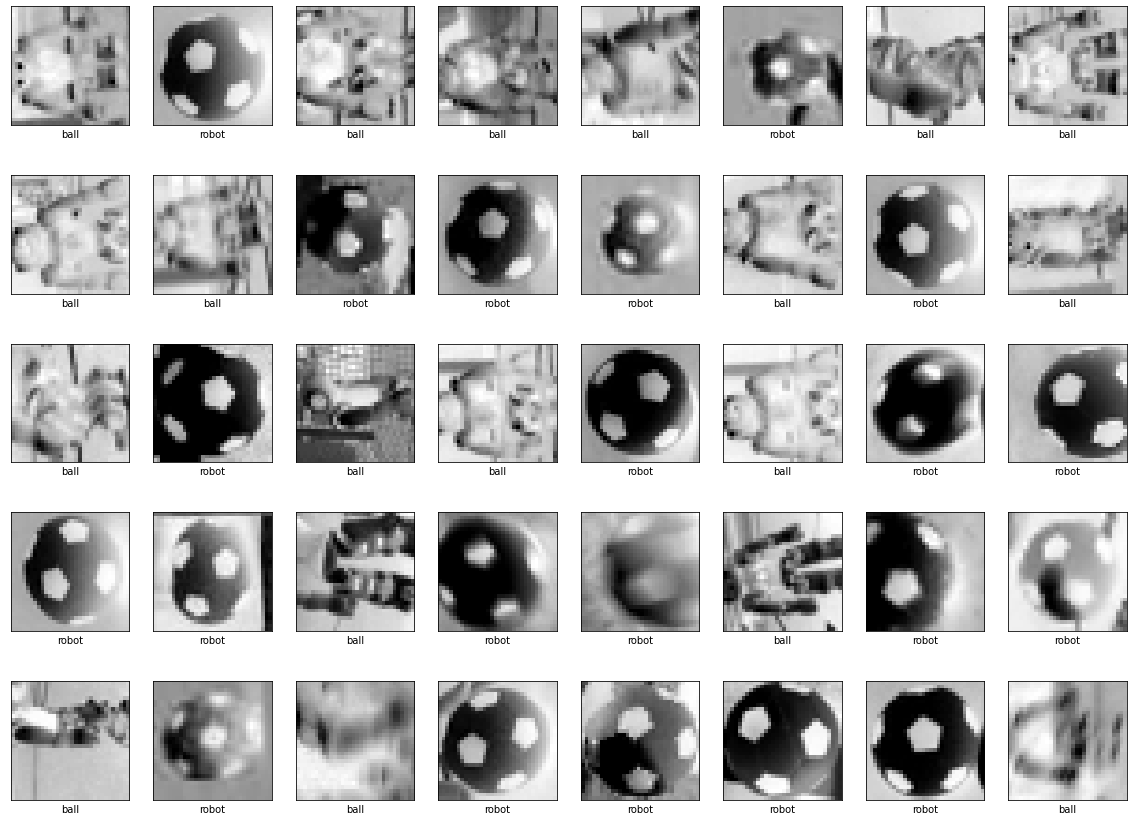

In [7]:
plt.figure(figsize=(20, 15))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
    
plt.show()

## Prepare Tensorflow Parameter

In [9]:
print(train_images.shape)

print(test_images.shape)

print(train_labels.shape)

print(test_labels.shape)





(8164, 32, 32, 1)
(3500, 32, 32, 1)
(8164, 11664)
(3500, 11664)


## Create neural network

## Train Model

## Evaluate Model

## Predict